## Predicting private property prices.

### There are many factors affecting private property prices. The aim of this study is to determine what are the key factors affecting private property prices.  These factors are analysed further on correlation against the selling price as well as each other. 

### Property in Singapore are boardly divided into 3 regions. The core central region (district 9,10,11, Sentosa), outside core central region (Telok Banglah, Queenstown, Toa Payoh, Geylang), rest of core central region (Punggol, East Coast, Jurong, Changi)

### The outliners in the studies has resulted in considerable variances in the prediction of property prices. It is suggested in future studies to reallocate a separate category to remove the impact of outliners.

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices, build_design_matrices

import patsy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import re
from collections import defaultdict 
# from selenium import webdriver
import time
import urllib.request
# from selenium.webdriver.common.action_chains import ActionChains

#settings
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)
pd.options.display.max_columns = None


### Webscraping data

In [ ]:
#run this to download data. Step 1
listing_link_list = []
for page in range(1,50):
    url = 'https://www.srx.com.sg/search/sale/condo?page=' + str(page) 
    #     Just like HTTP request, you ask the driver to open a browser and go to the following link!
    resp = requests.get(url)

    #     create a soup variable that parses the HTML into a BeautifulSoup object
    soup = BeautifulSoup(resp.text, 'html.parser')
    # print(soup.prettify())
    listing_link_string = soup.find_all('a', {'class': 'listingDetailsDivLink', 'href': True})

    for link in listing_link_string:
        listing_link = "https://www.srx.com.sg" + link["href"]
        listing_link_list.append(listing_link)


    print('End of page ' + str(page))

In [ ]:
#run this after download data. Step 2
condo_df = pd.DataFrame()

count=0 #initialise the first row in df
for link in listing_link_list:
    listing_resp = requests.get(link)
    listing_soup = BeautifulSoup(listing_resp.text, 'html.parser')

    about_this_property_section = listing_soup.find_all("div" ,attrs={"class": "row listing-about"})
    facilities_section = listing_soup.find_all("div" ,attrs={"class": "col-6 col-md-4 facilities-row"}) # facilities exists as span tags with attribute name 'listing-about-facility-span' 


    for item in about_this_property_section:
        property_keys = item.find("div",attrs={"class":"col-5"}).text
        property_values = item.find("div", class_=re.compile("^col-7")).text
        
        condo_df.loc[count, property_keys]=property_values #for each listing, if there's a corresponding value for the key, append the value. if not, it'll skip that key. 
    for facility in facilities_section:
        facilities_keys = facility.find("span",attrs={"class":"listing-about-facility-span"}).text
        if facilities_keys != np.nan: 
            facilities_values = 1
        else: 
            facilities_values = 0

        condo_df.loc[count,facilities_keys]=facilities_values
    count+=1

### Save webscrapped data into pickle.

In [ ]:
# run this to save file inside pc. Step 3
with open('kaplan/Project2 condo/condo_df.pickle', 'wb') as to_write:
    pickle.dump(condo_df, to_write) #run this file to download data into drive, so that need not download again.

In [2]:
# run this to open file inside pc. If file already downloaded, don't need to run Step 1-3
with open('kaplan/Project2 condo/condo_df.pickle','rb') as pickle_file:
    condo_data = pickle.load(pickle_file)
condo_df = condo_data # run this file when data has been download already. 

In [3]:
condo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980 entries, 0 to 979
Columns: 724 entries, Address to Spa Alcove
dtypes: float64(705), object(19)
memory usage: 5.4+ MB


In [4]:
condo_df.shape

(980, 724)

In [5]:
condo_df.dtypes

Address                                            object
Property Name                                      object
Property Type                                      object
Model                                              object
Bedrooms                                           object
Tenure                                             object
Developer                                          object
Built Year                                         object
No. of Units                                       object
District                                           object
Asking                                             object
Size                                               object
PSF                                                object
Tenancy Status                                     object
Sea View                                          float64
City View                                         float64
Air Conditioning                                  float64
Cooker Hob/hoo

## Data cleaning

In [ ]:
condo_df['Target'] = condo_df['Asking']
condo_df['Target']

In [7]:
condo_df['Target'] = condo_df['Asking'].map(lambda x: x.replace('\n','').replace('GuidePrice','').replace('(Viewtooffer)','').replace('(Guideprice)','').replace('(ViewtoOffer)','').replace('HIGH','').replace('GuidePrice','').replace(',','').replace('$','').replace(' ','').replace(' ()','').replace('()','').replace('Yes','').replace('\t','').replace('(Guide price)','').replace('X-Listing Price','').replace('Guide Price','').replace('(Negotiable)','').replace('Viewtooffer(TBA)','',).replace('(Best Buys units)',''))
condo_df['Target'].head()

0     4707391(GuidePrice)
1                 1305000
2     1020000(GuidePrice)
3                  740000
4    1998888(ViewtoOffer)
Name: Target, dtype: object

In [8]:
condo_df['Target1']=condo_df['Target'].str.extract('(\d+)').astype(float)
condo_df['Target1'].head()

0    4707391.0
1    1305000.0
2    1020000.0
3     740000.0
4    1998888.0
Name: Target1, dtype: float64

In [9]:
condo_df['Region']=condo_df['District']
condo_df['Region'] = condo_df["Region"].apply(lambda x: int(''.join(filter(str.isdigit, x))))
condo_df['Region'].head()

0     1
1    15
2     9
3    16
4    23
Name: Region, dtype: int64

### Mapping the data into regions

In [10]:
RegionDict = {1:'CCR', 2:'CCR', 6:'CCR', 9:'CCR', 10:'CCR', 11:'CCR', 3:'RCR', 4:'RCR',5:'RCR',6:'RCR',7:"RCR",8:"RCR",12:'RCR',13:'RCR',14:'RCR',15:'RCR',20:'RCR',16:'OCR',17:'OCR',18:'OCR',19:'OCR',21:'OCR',22:'OCR',23:'OCR',24:'OCR',25:'OCR',26:'OCR',27:'OCR',28:'OCR',29:'OCR' }

In [11]:
condo_df['Region1'] = condo_df['Region'].map(RegionDict)
condo_df.loc[:,('Region1','Region')]  #[:, ('Region1 shows region', 'Region shows district number')]

,Region1,Region
0,CCR,1
1,RCR,15
2,CCR,9
3,OCR,16
4,OCR,23
5,OCR,23
6,OCR,16
7,RCR,5
8,OCR,23
9,CCR,10


In [12]:
condo_df['Size1'] = condo_df["Size"].apply(lambda x: int(''.join(filter(str.isdigit, x))))
condo_df['Size1'].head()

0    1561
1     484
2     517
3     452
4    1367
Name: Size1, dtype: int64

In [13]:
condo_df["Built Year"] = pd.to_numeric(condo_df["Built Year"])

In [14]:
condo_df.dtypes['Built Year']

dtype('float64')

In [15]:
condo_df["Bedrooms1"]=condo_df['Bedrooms'].loc[condo_df['Bedrooms'].str.contains(r'[+()Studio]') == False]
condo_df["Bedrooms1"].head()

0    NaN
1      1
2      1
3      1
4      4
Name: Bedrooms1, dtype: object

Remove + and other string from column Bedrooms

Remove studio from bedrooms1 list

In [16]:
condo_df["Bedrooms1"] = pd.to_numeric(condo_df["Bedrooms1"])
condo_df["Bedrooms1"].dtypes

dtype('float64')

In [17]:
condo_df["Bathrooms1"] = pd.to_numeric(condo_df["Bathrooms"])
condo_df["Bathrooms1"].dtypes

dtype('float64')

Remove object e.g /n,view to offer, guide price from string and convert to integer

In [18]:
condo_df[['Target1','Region1','Size1','Built Year','Bedrooms1','Bathrooms1']].sort_values(by=['Target1'])

,Target1,Region1,Size1,Built Year,Bedrooms1,Bathrooms1
546,475000.0,OCR,398,2016.0,1.0,1.0
248,499000.0,OCR,398,2016.0,1.0,NaN
882,558000.0,OCR,506,2014.0,1.0,NaN
915,560000.0,RCR,398,2013.0,1.0,1.0
948,610000.0,RCR,431,2015.0,1.0,1.0
922,620000.0,OCR,409,2010.0,NaN,1.0
939,650000.0,RCR,452,2014.0,NaN,1.0
589,650000.0,CCR,334,2012.0,1.0,1.0
545,650688.0,RCR,431,2015.0,1.0,NaN
232,658000.0,OCR,484,2018.0,1.0,1.0


In [19]:
condo_df = condo_df.dropna(subset=['Target1'])
condo_df['Target1'].shape

(914,)

In [20]:
condo_df[['Target1','Region1','Size1','Built Year','Bedrooms1','Bathrooms1']].sort_values(by=['Target1'])

,Target1,Region1,Size1,Built Year,Bedrooms1,Bathrooms1
546,475000.0,OCR,398,2016.0,1.0,1.0
248,499000.0,OCR,398,2016.0,1.0,NaN
882,558000.0,OCR,506,2014.0,1.0,NaN
915,560000.0,RCR,398,2013.0,1.0,1.0
948,610000.0,RCR,431,2015.0,1.0,1.0
922,620000.0,OCR,409,2010.0,NaN,1.0
939,650000.0,RCR,452,2014.0,NaN,1.0
589,650000.0,CCR,334,2012.0,1.0,1.0
545,650688.0,RCR,431,2015.0,1.0,NaN
232,658000.0,OCR,484,2018.0,1.0,1.0


In [21]:
condo_df['No. of Units1']= pd.to_numeric(condo_df["No. of Units"])
condo_df['No. of Units1'].head()

<ipython-input-21-0da896f14c98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condo_df['No. of Units1']= pd.to_numeric(condo_df["No. of Units"])


0    1042.0
1     200.0
2     378.0
3     726.0
4     437.0
Name: No. of Units1, dtype: float64

### Checking the data cleaned.

In [22]:
condo_df1 =condo_df[['Target1','Region1','Size1','Built Year','Bedrooms1','Bathrooms1','No. of Units1']].sort_values(by=['Target1'])
condo_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 546 to 118
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Target1        914 non-null    float64
 1   Region1        914 non-null    object 
 2   Size1          914 non-null    int64  
 3   Built Year     436 non-null    float64
 4   Bedrooms1      796 non-null    float64
 5   Bathrooms1     814 non-null    float64
 6   No. of Units1  913 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 57.1+ KB


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015A55773130>,
      dtype=object)

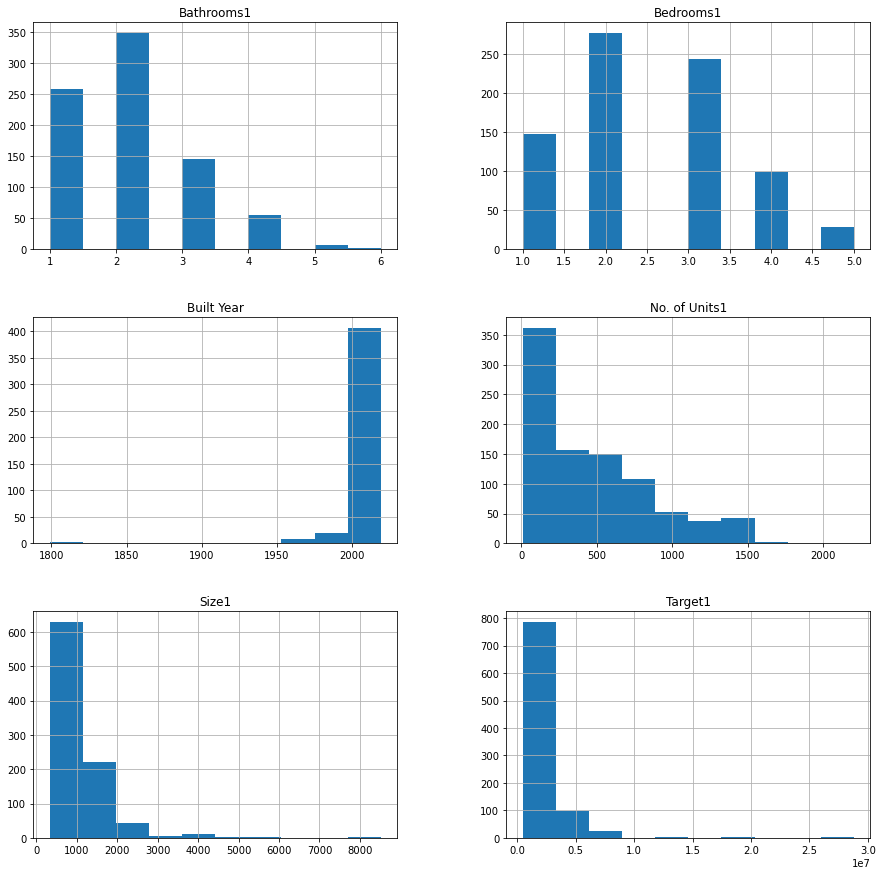

In [24]:
pd.DataFrame.hist(condo_df1,figsize=[15,15])

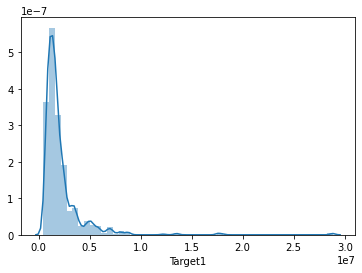

In [25]:
#sns.distsns_plot = sns.pairplot(df1, hue='species', size=2.5)
sns.distplot(condo_df1["Target1"])
plt.savefig('Target1.png')
plt.show()



((array([-3.17157283e+00, -2.90435131e+00, -2.75509777e+00, -2.64976531e+00,
         -2.56754733e+00, -2.49971313e+00, -2.44173921e+00, -2.39096813e+00,
         -2.34570127e+00, -2.30478474e+00, -2.26739769e+00, -2.23293467e+00,
         -2.20093588e+00, -2.17104364e+00, -2.14297403e+00, -2.11649778e+00,
         -2.09142699e+00, -2.06760571e+00, -2.04490297e+00, -2.02320773e+00,
         -2.00242497e+00, -1.98247274e+00, -1.96327984e+00, -1.94478403e+00,
         -1.92693054e+00, -1.90967092e+00, -1.89296212e+00, -1.87676567e+00,
         -1.86104708e+00, -1.84577530e+00, -1.83092225e+00, -1.81646247e+00,
         -1.80237281e+00, -1.78863213e+00, -1.77522108e+00, -1.76212192e+00,
         -1.74931832e+00, -1.73679523e+00, -1.72453874e+00, -1.71253597e+00,
         -1.70077496e+00, -1.68924461e+00, -1.67793457e+00, -1.66683518e+00,
         -1.65593742e+00, -1.64523284e+00, -1.63471353e+00, -1.62437207e+00,
         -1.61420146e+00, -1.60419514e+00, -1.59434691e+00, -1.58465093e+00,

Text(0.5, 1.0, 'Normal Q-Q plot')

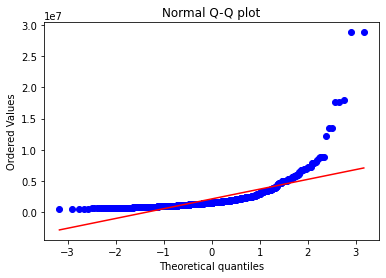

In [26]:
from scipy import stats
stats.probplot(condo_df1['Target1'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

plt.savefig('Qplot1a.png')
plt.show()

In [27]:
print("skewness: %f" % condo_df['Target1'].skew())
print("kurtosis: %f" % condo_df['Target1'].kurt())

skewness: 6.199612
kurtosis: 59.134594


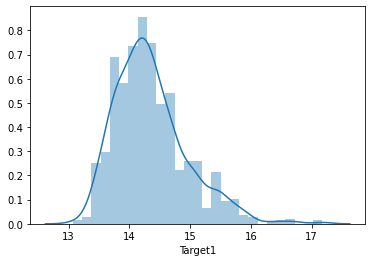

In [28]:
sns.distplot(np.log(condo_df['Target1']))
plt.savefig('Target2.png')
plt.show()


((array([-3.17157283e+00, -2.90435131e+00, -2.75509777e+00, -2.64976531e+00,
         -2.56754733e+00, -2.49971313e+00, -2.44173921e+00, -2.39096813e+00,
         -2.34570127e+00, -2.30478474e+00, -2.26739769e+00, -2.23293467e+00,
         -2.20093588e+00, -2.17104364e+00, -2.14297403e+00, -2.11649778e+00,
         -2.09142699e+00, -2.06760571e+00, -2.04490297e+00, -2.02320773e+00,
         -2.00242497e+00, -1.98247274e+00, -1.96327984e+00, -1.94478403e+00,
         -1.92693054e+00, -1.90967092e+00, -1.89296212e+00, -1.87676567e+00,
         -1.86104708e+00, -1.84577530e+00, -1.83092225e+00, -1.81646247e+00,
         -1.80237281e+00, -1.78863213e+00, -1.77522108e+00, -1.76212192e+00,
         -1.74931832e+00, -1.73679523e+00, -1.72453874e+00, -1.71253597e+00,
         -1.70077496e+00, -1.68924461e+00, -1.67793457e+00, -1.66683518e+00,
         -1.65593742e+00, -1.64523284e+00, -1.63471353e+00, -1.62437207e+00,
         -1.61420146e+00, -1.60419514e+00, -1.59434691e+00, -1.58465093e+00,

Text(0.5, 1.0, 'Normal Q-Q plot')

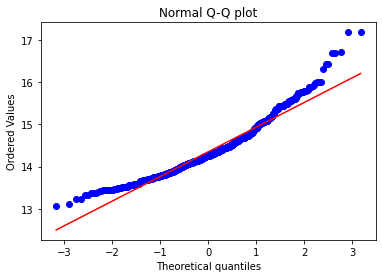

In [29]:
stats.probplot(np.log(condo_df['Target1']), dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.savefig('Qplot2.png')
plt.show()

plt.show()

In [30]:
print("skewness: %f" % np.log(condo_df['Target1']).skew())
print("kurtosis: %f" % np.log(condo_df['Target1']).kurt())

skewness: 1.023699
kurtosis: 1.615142


### Running the correlation among features

In [31]:
condo_df1.corr()

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1
Target1,1.000000,0.853593,0.036171,0.511313,0.528990,-0.197258
Size1,0.853593,1.000000,0.019293,0.703720,0.734647,-0.100170
Built Year,0.036171,0.019293,1.000000,0.012985,0.033389,-0.054105
Bedrooms1,0.511313,0.703720,0.012985,1.000000,0.776605,-0.001910
Bathrooms1,0.528990,0.734647,0.033389,0.776605,1.000000,-0.069529
No. of Units1,-0.197258,-0.100170,-0.054105,-0.001910,-0.069529,1.000000


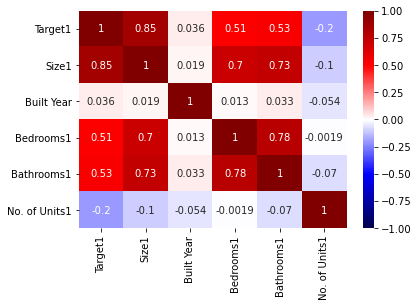

In [32]:
sns.heatmap(condo_df1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
plt.savefig('heatmap1.png')
plt.show()

In [33]:
condo_df1.sort_values(['Target1'],ascending=False).head(5)

,Target1,Region1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1
118,28800000.0,CCR,8513,2013.0,5.0,NaN,221.0
392,28800000.0,CCR,8513,2013.0,5.0,NaN,221.0
30,18000000.0,CCR,4478,2013.0,4.0,4.0,28.0
970,17600000.0,CCR,3767,2015.0,5.0,1.0,40.0
950,17600000.0,CCR,3767,2015.0,5.0,1.0,40.0


In [34]:
condo_df1 =condo_df[['Target1','Size1','Built Year','Bedrooms1','Bathrooms1','No. of Units1','Region1']].sort_values(by=['Target1'])
condo_df1.head()

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1
546,475000.0,398,2016.0,1.0,1.0,281.0,OCR
248,499000.0,398,2016.0,1.0,NaN,281.0,OCR
882,558000.0,506,2014.0,1.0,NaN,689.0,OCR
915,560000.0,398,2013.0,1.0,1.0,157.0,RCR
948,610000.0,431,2015.0,1.0,1.0,15.0,RCR


In [35]:
condo_df['Tenure'].head()

0    LEASEHOLD/99 years
1              FREEHOLD
2    LEASEHOLD/99 years
3    LEASEHOLD/99 years
4    LEASEHOLD/99 years
Name: Tenure, dtype: object

In [36]:
condo_df['Tenure1'] = condo_df['Tenure'].map(lambda x: x.replace('956 years from 27/05/1928','FREEHOLD').replace('110 years from 01/11/2017','LEASEHOLD').replace('999 years','FREEHOLD').replace('/60 years','').replace('/103 years','').replace('/99 years','').replace('99 years from 24/12/2018','LEASEHOLD').replace('999 years','FREEHOLD'))
condo_df['Tenure1'].head()

<ipython-input-36-e79ed7d2a6dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condo_df['Tenure1'] = condo_df['Tenure'].map(lambda x: x.replace('956 years from 27/05/1928','FREEHOLD').replace('110 years from 01/11/2017','LEASEHOLD').replace('999 years','FREEHOLD').replace('/60 years','').replace('/103 years','').replace('/99 years','').replace('99 years from 24/12/2018','LEASEHOLD').replace('999 years','FREEHOLD'))


0    LEASEHOLD
1     FREEHOLD
2    LEASEHOLD
3    LEASEHOLD
4    LEASEHOLD
Name: Tenure1, dtype: object

In [37]:
condo_df['Tenure1'].value_counts()

LEASEHOLD    547
FREEHOLD     364
99 Years       3
Name: Tenure1, dtype: int64

In [38]:
condo_df['Tenure1'] = condo_df['Tenure1'].map(lambda x: x.replace('99 Years','LEASEHOLD'))

<ipython-input-38-cd2db4a6b86c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condo_df['Tenure1'] = condo_df['Tenure1'].map(lambda x: x.replace('99 Years','LEASEHOLD'))


In [39]:
condo_df['Tenure1'].value_counts()

LEASEHOLD    550
FREEHOLD     364
Name: Tenure1, dtype: int64

In [40]:
condo_df['Tenure1'].shape

(914,)

In [41]:
condo_df['Region1'].value_counts()

RCR    334
CCR    319
OCR    261
Name: Region1, dtype: int64

In [42]:
condo_df = condo_df.loc[:,~condo_df.columns.duplicated(),]
condo_df.head(3)

,Address,Property Name,Property Type,Model,Bedrooms,Tenure,Developer,Built Year,No. of Units,District,Asking,Size,PSF,Tenancy Status,Sea View,City View,Air Conditioning,Cooker Hob/hood,Private Lift,Balcony,Walk-in-wardrobe,TOP,Park/greenery View,Swimming Pool View,Original Condition,Intercom,Water Heater,Bathrooms,Furnish,Floor Level,Renovated,Bbq Pavilion,Children's Playground,Dining Pavilion,Function Room,Gym,Jogging Trail,Swimming Pool,Tennis Court,Terrace Waterfalls,Clubhouse,Fitness Station,Kids Pool,Leisure Pool,Outdoor Dining Pavilion,Steam Bath,Sun Deck,Corner Unit,Bathtub,Jacuzzi,Maidsroom,Arrival Court,Bio-pond Garden,Canopy Deck,Club House,Fitness Corners,Garden Deck,Hammock Court,Look Out Tower,Reflecting Ponds,Side Gates,Spa Pools,The Hideout Lagoon,The Trail,Tree House,Barbecue Area,Fitness Area,Gymnasium,Landscaped Garden,Securities,Flooring For Living/dining,Flooring For Bedroom,Wardrobe,Kitchen,Air-conditioning,Aqua Gym,Bubbly Bay,Cinnamon Scent,Cloves Hedge,Club Lounge,Day Bed Island,Epicurean Dining,Garden Lounge,Indoor Gymnasium,Junior Pool,Outback Grill,Outdoor Fitness,Playscape,Refreshment Bar,Spa Pool,Spice Botanics,Splash Zone,Surf Lounge,Bombshelter,Wading Pool,Tenanted Amount,Outdoor Patio,Fitness Corner,Pavillion,Playground,Tennis Courts,Hairdryer,50M Lap Pool,Aquatic Gym,Bbq Piazza,Cradling Pavilion,Fitness Nook,Floating Cabana,Grand Piazza,Greenhaus,Hammock Island,Jacuzzi Garden,Jacuzzi Island,Jet Spa,Jogging Track,Play Lagoon,Play Scape,Play Splash,Settees,Sunken Lounge,Tea Orchard,Yoga Deck,Children's Play Pool,Children's Play Zone,Entertainment Pavilion With Jacuzzi,Garden Court,Grand Enterance,Guard House,Hydro-fitness Pool,Hydro-therapy Pool,Leisure Lounge,Olympic-length Grand Pool,Reflective Pool,Sculptural Slope,Serenity Deck,Side Gate,The Runway,Water Curtain,Water Steps,Wave Lounge,Wellness Station,50M Lap Pool With Sun Deck,Bbq Pavilions,Bin Centre,Cabana With Jacuzzi,Children's Party Area,Covered Linkway To Bus Stop,Entry Court,Entry To Carpark,Exit From Carpark,Hydrotherapy Pool With Aqua Gym,Lifestyle Pool,Outdoor Fitness Area,Pool Decks,Private Dining Pavilion,Relaxation Pavilion,Sky Terrace,Spa Pavilions With Jacuzzi,Substation,Water Court,Private Pool,Basketball Court,Bbq,Clubhouses,Event Courts,Fitness Areas,Jacuzzis,Jogging Tracks,Lap Pool / Gym Pool,Mini Race Track,Multi-purpose Court,Play Areas,Restaurant/retail Space,Spa Pavilions,Theme Gardens,Car Park,Meeting Rooms,Private Garden,Terrace,Bbq Pits,Entertainment Terrace,Lap Pool,Lounge Terrace,Spa Lounge,Lawn,Pooldeck,Reading Corner,Yoga Station,Aqua Play,Blue Lagoon,Dining Deck,Dip Lagoon,Eco Spring,Fitness Courts,Fun Court,Gourmet Pavilion,Hammock Haven,Hydro Gym,Massage Cabana,Meditation Bay,Pizza Pavilion,Pools Of Reflection,River Ford,Spa Beds,Spa Seats,Tee Square,Teppanyaki Pavilion,The Glade,Wade 'n' Waddle,Water Spring Massage,Alcoves,Bbq Trellis,Bioswale,Canopy Walk,Forest Oasis,Multi Purpose Court,Palm Court,Play Agora,Sky Deck,Urban Farm,Viewing Gallery,Alfresco Outdoor Dining,Aqua Garden,Basement Carpark,Bbq Pavillion,Children Play Pool,Children Playground,Cycling/jogging Track,Fitness Park,Fitness Pool,Multi-function Room,Play Pool,Pool Pavillion,Play Ground,Squash Court,Multi Purpose Hall,Bay Villas,Lifestyle Pavilions With Spa Pool,Main Entrance Drop Off Area,Main Pavilion,Main Pool,Male & Female Changing Rooms With Steam Bath,Multipurpose Court,Reflective Pools,Sunbathing Decks,Bbq Area,Children's Splash Fun Pool,Lounge Pavilion,Lounge Pool With Spa Seats & Spa Beds,Outdoor Spa Pool,Palm Court Cum Sun Deck,Playzone,Putting Green,Reflective Ponds,Sauna Room,Splash Deck,Steam Room,Water Feature Walls,Changing Rooms,Jacuzzi / Hydro Spa,Kid's Pool / Splash Pool With Jumping Jets,Pathway / Forest Walk,Play Area,Public Promenade,Water Feature,Adventure Playground,Amphitheatre Deck,Aqua-gym Pool With Cascades,Children's Pool,Children's Waterjet Platform,Courtyard Garden,Drop-off Reflecting Pool And Waterfall,Hot Spa En

### Creating dummy variables for region (region1) and tenure (tenure1)

In [43]:
condo_df1 = condo_df[['Target1','Size1','Built Year', 'Bedrooms1','Bathrooms1','No. of Units1','Region1','Tenure1']]
condo_df1.head()

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1,Tenure1
0,4707391.0,1561,2017.0,NaN,NaN,1042.0,CCR,LEASEHOLD
1,1305000.0,484,NaN,1.0,NaN,200.0,RCR,FREEHOLD
2,1020000.0,517,NaN,1.0,1.0,378.0,CCR,LEASEHOLD
3,740000.0,452,2016.0,1.0,1.0,726.0,OCR,LEASEHOLD
4,1998888.0,1367,2016.0,4.0,4.0,437.0,OCR,LEASEHOLD


In [44]:
pd.get_dummies(condo_df1,prefix=['Region1','Tenure1']).head(5)

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_CCR,Region1_OCR,Region1_RCR,Tenure1_FREEHOLD,Tenure1_LEASEHOLD
0,4707391.0,1561,2017.0,NaN,NaN,1042.0,1,0,0,0,1
1,1305000.0,484,NaN,1.0,NaN,200.0,0,0,1,1,0
2,1020000.0,517,NaN,1.0,1.0,378.0,1,0,0,0,1
3,740000.0,452,2016.0,1.0,1.0,726.0,0,1,0,0,1
4,1998888.0,1367,2016.0,4.0,4.0,437.0,0,1,0,0,1


In [45]:
condo_df1 = pd.get_dummies(condo_df1, drop_first = True) #can just apply it to the whole df
condo_df1.head(3)

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
0,4707391.0,1561,2017.0,NaN,NaN,1042.0,0,0,1
1,1305000.0,484,NaN,1.0,NaN,200.0,0,1,0
2,1020000.0,517,NaN,1.0,1.0,378.0,0,0,1


In [46]:
condo_df1.fillna(condo_df1.median(), inplace= True)
condo_df1

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
0,4707391.0,1561,2017.0,2.0,2.0,1042.0,0,0,1
1,1305000.0,484,2014.0,1.0,2.0,200.0,0,1,0
2,1020000.0,517,2014.0,1.0,1.0,378.0,0,0,1
3,740000.0,452,2016.0,1.0,1.0,726.0,1,0,1
4,1998888.0,1367,2016.0,4.0,4.0,437.0,1,0,1
5,1450000.0,1410,2015.0,3.0,3.0,466.0,1,0,1
6,1498000.0,1260,2009.0,3.0,3.0,556.0,1,0,1
7,938400.0,614,2014.0,2.0,1.0,716.0,0,1,1
8,1050000.0,732,2016.0,2.0,2.0,437.0,1,0,1
9,2600000.0,657,2014.0,2.0,2.0,96.0,0,0,0


In [47]:
condo_df2 = condo_df1
condo_df2

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
0,4707391.0,1561,2017.0,2.0,2.0,1042.0,0,0,1
1,1305000.0,484,2014.0,1.0,2.0,200.0,0,1,0
2,1020000.0,517,2014.0,1.0,1.0,378.0,0,0,1
3,740000.0,452,2016.0,1.0,1.0,726.0,1,0,1
4,1998888.0,1367,2016.0,4.0,4.0,437.0,1,0,1
5,1450000.0,1410,2015.0,3.0,3.0,466.0,1,0,1
6,1498000.0,1260,2009.0,3.0,3.0,556.0,1,0,1
7,938400.0,614,2014.0,2.0,1.0,716.0,0,1,1
8,1050000.0,732,2016.0,2.0,2.0,437.0,1,0,1
9,2600000.0,657,2014.0,2.0,2.0,96.0,0,0,0


### Training the data for linear regression, logistic regression and polynominal regression

In [48]:
X, y = condo_df2.drop('Target1',axis=1), condo_df2['Target1']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=11)


In [49]:
condo_df2.head()
#condo_df2 = condo_df1.fillna(condo_df1.median(), inplace= True)
#condo_df2

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
0,4707391.0,1561,2017.0,2.0,2.0,1042.0,0,0,1
1,1305000.0,484,2014.0,1.0,2.0,200.0,0,1,0
2,1020000.0,517,2014.0,1.0,1.0,378.0,0,0,1
3,740000.0,452,2016.0,1.0,1.0,726.0,1,0,1
4,1998888.0,1367,2016.0,4.0,4.0,437.0,1,0,1


In [50]:
X

,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
343,700,2014.0,2.0,1.0,119.0,0,0,1
834,527,2014.0,1.0,1.0,60.0,0,0,0
691,1732,2009.0,3.0,3.0,20.0,0,1,0
817,431,2016.0,1.0,1.0,810.0,1,0,1
274,1216,2017.0,2.0,2.0,109.0,0,1,0
635,635,2014.0,2.0,1.0,285.0,0,0,0
852,1131,2010.0,2.0,2.0,50.0,1,0,0
579,1518,2017.0,3.0,2.0,1042.0,0,0,1
472,624,2014.0,2.0,1.0,250.0,1,0,0
679,1163,1999.0,3.0,3.0,30.0,1,0,0


In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [52]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [53]:
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

LinearRegression()

Linear Regression val R^2: 0.390


Ridge(alpha=1)

Ridge Regression val R^2: 0.394


LinearRegression()

Degree 2 polynomial regression val R^2: 0.617


In [54]:
condo_df2['Target1'] = condo_df1['Target1']

In [55]:
condo_df2

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
0,4707391.0,1561,2017.0,2.0,2.0,1042.0,0,0,1
1,1305000.0,484,2014.0,1.0,2.0,200.0,0,1,0
2,1020000.0,517,2014.0,1.0,1.0,378.0,0,0,1
3,740000.0,452,2016.0,1.0,1.0,726.0,1,0,1
4,1998888.0,1367,2016.0,4.0,4.0,437.0,1,0,1
5,1450000.0,1410,2015.0,3.0,3.0,466.0,1,0,1
6,1498000.0,1260,2009.0,3.0,3.0,556.0,1,0,1
7,938400.0,614,2014.0,2.0,1.0,716.0,0,1,1
8,1050000.0,732,2016.0,2.0,2.0,437.0,1,0,1
9,2600000.0,657,2014.0,2.0,2.0,96.0,0,0,0


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

X, y = condo_df2.drop('Target1',axis=1), condo_df2['Target1']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=3)

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [58]:
X_train.head()

,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
636,441,2018.0,1.0,1.0,221.0,0,0,0
676,2260,2017.0,4.0,4.0,80.0,0,0,0
609,614,2014.0,2.0,1.0,378.0,0,0,1
529,700,2014.0,2.0,2.0,566.0,0,1,1
148,1313,2019.0,2.0,4.0,578.0,0,1,1


In [59]:
lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [60]:
X_train.head()

,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
636,441,2018.0,1.0,1.0,221.0,0,0,0
676,2260,2017.0,4.0,4.0,80.0,0,0,0
609,614,2014.0,2.0,1.0,378.0,0,0,1
529,700,2014.0,2.0,2.0,566.0,0,1,1
148,1313,2019.0,2.0,4.0,578.0,0,1,1


In [61]:
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

LinearRegression()

Linear Regression val R^2: 0.784


Ridge(alpha=1)

Ridge Regression val R^2: 0.784


LinearRegression()

Degree 2 polynomial regression val R^2: 0.699


In [62]:
X_train_poly.shape

(548, 45)

In [63]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

LinearRegression()

Linear Regression test R^2: 0.807


In [64]:
#condo_df3 = condo_df2[['Target1','Size1','Bedrooms1','Bathrooms1','Region1_OCR','Region1_RCR']]
condo_df2.head()

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
0,4707391.0,1561,2017.0,2.0,2.0,1042.0,0,0,1
1,1305000.0,484,2014.0,1.0,2.0,200.0,0,1,0
2,1020000.0,517,2014.0,1.0,1.0,378.0,0,0,1
3,740000.0,452,2016.0,1.0,1.0,726.0,1,0,1
4,1998888.0,1367,2016.0,4.0,4.0,437.0,1,0,1


In [68]:
from sklearn.model_selection import KFold

X, y = condo_df2.drop('Target1',axis=1), condo_df2['Target1']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=60) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [69]:
kf = KFold(n_splits=5, shuffle=True, random_state = 60)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

LinearRegression()

Ridge(alpha=1)

LinearRegression()

Ridge(alpha=1)

LinearRegression()

Ridge(alpha=1)

LinearRegression()

Ridge(alpha=1)

LinearRegression()

Ridge(alpha=1)

Simple regression scores:  [0.8776541883643045, 0.6825715781756685, 0.8220825629607812, 0.724671194953898, 0.7573144132931007]
Ridge scores:  [0.8768244267824242, 0.6848373985577889, 0.8219330246884026, 0.7246547408510495, 0.7574914834052251] 

Simple mean cv r^2: 0.773 +- 0.069
Ridge mean cv r^2: 0.773 +- 0.069


In [70]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge(alpha=1)

Ridge Regression test R^2: 0.573


In [71]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.84263369, 0.65121387, 0.87522425, 0.67082049, 0.86417241])

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.67299226, 0.85388024, 0.70213295, 0.72986995, 0.89263458])

In [73]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.7703019973687166
0.7703575206605785


### Using OLS to evaluate the model.

In [74]:
Y = condo_df1['Target1']
X1 = condo_df1['Size1']
X2 = condo_df1['Built Year']
X3 = condo_df1['Bedrooms1']
X4 = condo_df1['Bathrooms1']
X5 = condo_df1['No. of Units1']
X6 = condo_df1['Region1_OCR']
X7= condo_df1['Region1_RCR']
X8= condo_df1['Tenure1_LEASEHOLD']
y, X = patsy.dmatrices('Y ~ X1 +X2+ X3+X4+ X5 + X6 + X7 + X8 ', data=condo_df1, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     515.7
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:04:32   Log-Likelihood:                -13849.
No. Observations:                 914   AIC:                         2.772e+04
Df Residuals:                     905   BIC:                         2.776e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.232e+07   5.13e+06     -2.400      0.017   -2.24e+07   -2.25e+06
X1          2773.2767     59.796     46.379      0.000    2655.921    2890.632
X2          6547.5073   2549.794      2.568      0.010    1543.311    1.16e+04
X3          -8.98e+04   4.47e+04     -2.011      0.045   -1.77e+05   -2145.026
X4         -3.207e+05   4.69e+04     -6.837      0.000   -4.13e+05   -2.29e+05
X5           -73.4683     99.456     -0.739      0.460    -268.659     121.723
X6         -1.302e+06    8.7e+04    -14.967      0.000   -1.47e+06   -1.13e+06
X7         -9.232e+05   7.75e+04    -11.918      0.000   -1.08e+06   -7.71e+05
X8         -1.185e+05   8.53e+04     -1.388      0.165   -2.86e+05     4.9e+04
==============================================================================
Omnibus:                      264.977   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14817.189
Skew:                           0.431   Prob(JB):                         0.00
Kurtosis:                      22.706   Cond. No.                     3.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
Y = condo_df1['Target1']
X1 = condo_df1['Size1']
X2 = condo_df1['Built Year']
X3 = condo_df1['Bedrooms1']
#X4 = condo_df1['Bathrooms1']
#X5 = condo_df1['No. of Units1']
X6 = condo_df1['Region1_OCR']
X7= condo_df1['Region1_RCR']
#X8= condo_df1['Tenure1_LEASEHOLD']
y, X = patsy.dmatrices('Y ~ X1 + X2 + X3+X6+X7', data=condo_df1, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     775.1
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:04:33   Log-Likelihood:                -13874.
No. Observations:                 914   AIC:                         2.776e+04
Df Residuals:                     908   BIC:                         2.779e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.276e+07   5.24e+06     -2.438      0.015    -2.3e+07   -2.49e+06
X1          2644.4314     57.676     45.850      0.000    2531.238    2757.625
X2          6620.5771   2600.976      2.545      0.011    1515.954    1.17e+04
X3         -2.022e+05   4.25e+04     -4.754      0.000   -2.86e+05   -1.19e+05
X6          -1.39e+06   8.05e+04    -17.273      0.000   -1.55e+06   -1.23e+06
X7         -9.861e+05   7.48e+04    -13.183      0.000   -1.13e+06   -8.39e+05
==============================================================================
Omnibus:                      431.861   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22316.297
Skew:                           1.374   Prob(JB):                         0.00
Kurtosis:                      27.051   Cond. No.                     3.84e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
Y = condo_df1['Target1']
X1 = condo_df1['Size1']
#X2 = condo_df1['Built Year']
X3 = condo_df1['Bedrooms1']
#X4 = condo_df1['Bathrooms1']
#X5 = condo_df1['No. of Units1']
X6 = condo_df1['Region1_OCR']
X7= condo_df1['Region1_RCR']
#X8= condo_df1['Tenure1_LEASEHOLD']
y, X = patsy.dmatrices('Y ~ X1 + X3 +X6+X7', data=condo_df1, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     961.4
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:04:34   Log-Likelihood:                -13877.
No. Observations:                 914   AIC:                         2.776e+04
Df Residuals:                     909   BIC:                         2.779e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.595e+05   9.24e+04      6.056      0.000    3.78e+05    7.41e+05
X1          2640.9310     57.833     45.665      0.000    2527.429    2754.433
X3         -2.012e+05   4.27e+04     -4.716      0.000   -2.85e+05   -1.18e+05
X6         -1.394e+06   8.07e+04    -17.279      0.000   -1.55e+06   -1.24e+06
X7         -9.858e+05    7.5e+04    -13.140      0.000   -1.13e+06   -8.39e+05
==============================================================================
Omnibus:                      430.461   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22120.099
Skew:                           1.368   Prob(JB):                         0.00
Kurtosis:                      26.945   Cond. No.                     4.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Heatmap on all features including dummy variables.

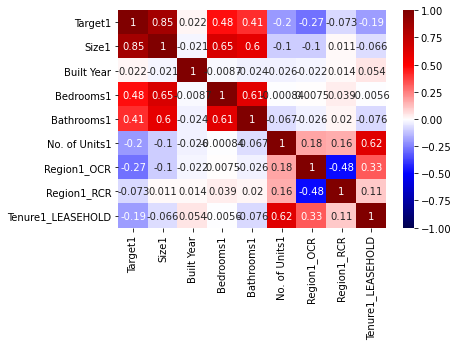

In [77]:
sns.heatmap(condo_df2.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

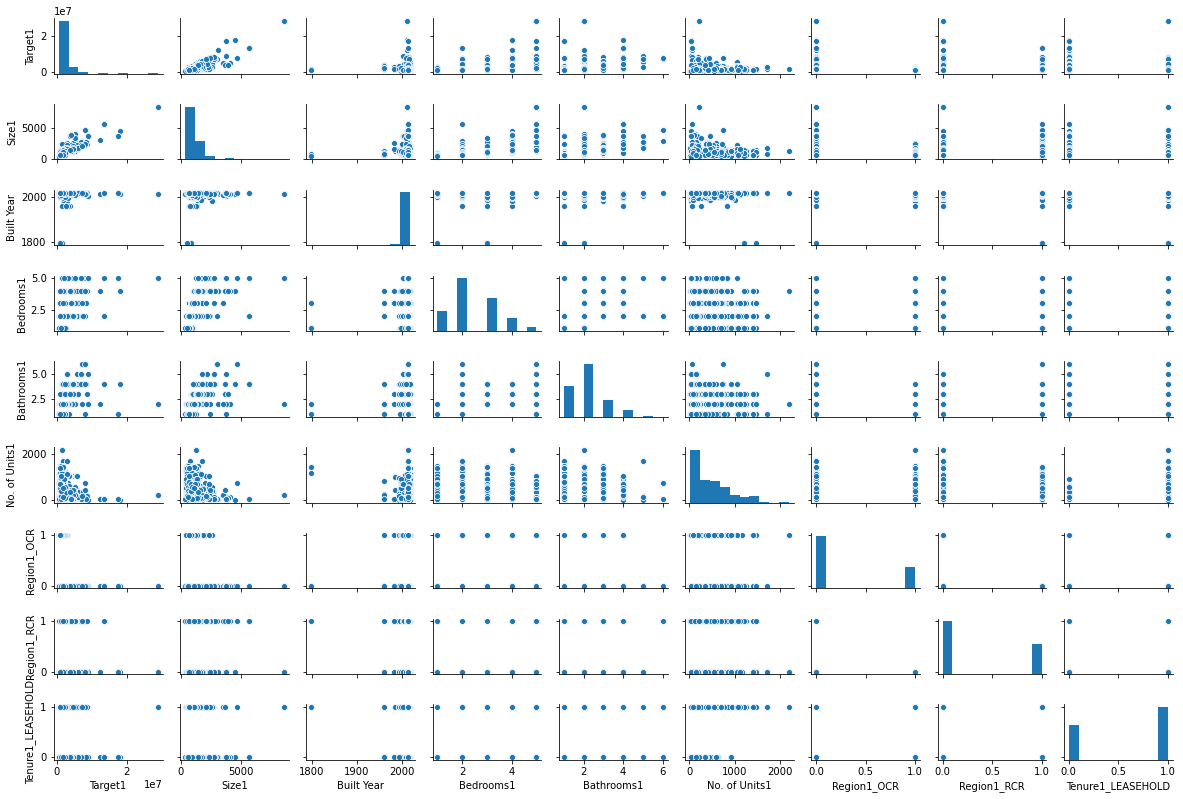

In [78]:
sns.pairplot(condo_df2, height=1.2, aspect=1.5);

### Log the target to view the distribution

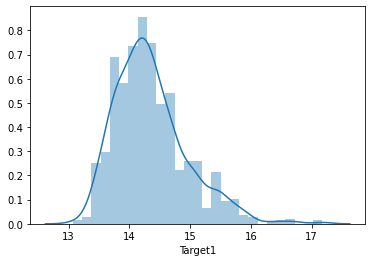

In [79]:
sns.distplot(np.log(condo_df2['Target1']))

In [80]:
condo_df2.corr()

,Target1,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1_OCR,Region1_RCR,Tenure1_LEASEHOLD
Target1,1.000000,0.853593,0.021939,0.475799,0.407398,-0.197367,-0.274952,-0.073332,-0.194235
Size1,0.853593,1.000000,-0.021465,0.651785,0.598762,-0.100432,-0.100652,0.010888,-0.065586
Built Year,0.021939,-0.021465,1.000000,-0.008702,-0.023761,-0.025507,-0.022076,0.013801,0.054055
Bedrooms1,0.475799,0.651785,-0.008702,1.000000,0.614866,-0.000837,0.007536,0.038978,-0.005595
Bathrooms1,0.407398,0.598762,-0.023761,0.614866,1.000000,-0.066988,-0.026325,0.019601,-0.075753
No. of Units1,-0.197367,-0.100432,-0.025507,-0.000837,-0.066988,1.000000,0.178981,0.162267,0.620749
Region1_OCR,-0.274952,-0.100652,-0.022076,0.007536,-0.026325,0.178981,1.000000,-0.479759,0.326292
Region1_RCR,-0.073332,0.010888,0.013801,0.038978,0.019601,0.162267,-0.479759,1.000000,0.106818
Tenure1_LEASEHOLD,-0.194235,-0.065586,0.054055,-0.005595,-0.075753,0.620749,0.326292,0.106818,1.000000


In [81]:
corr_sale = condo_df2.corr().Target1

In [82]:
corr_field = corr_sale.sort_values(ascending = False).head(11)
corr_field

Target1              1.000000
Size1                0.853593
Bedrooms1            0.475799
Bathrooms1           0.407398
Built Year           0.021939
Region1_RCR         -0.073332
Tenure1_LEASEHOLD   -0.194235
No. of Units1       -0.197367
Region1_OCR         -0.274952
Name: Target1, dtype: float64

In [83]:
corr_field = corr_field.drop(['Target1']).index

In [84]:
corr_field 

Index(['Size1', 'Bedrooms1', 'Bathrooms1', 'Built Year', 'Region1_RCR',
       'Tenure1_LEASEHOLD', 'No. of Units1', 'Region1_OCR'],
      dtype='object')

In [85]:
y_log=np.log(condo_df2.Target1)
y_log

0      15.364644
1      14.081714
2      13.835313
3      13.514405
4      14.508102
5      14.187074
6      14.219641
7      13.751932
8      13.864301
9      14.771022
10     15.128088
11     13.843126
12     14.901179
13     15.548404
14     13.717126
15     14.285514
16     14.690979
17     15.441609
18     14.430696
20     13.864301
21     14.285514
22     13.471611
23     14.014361
24     13.710150
25     14.327136
26     14.547878
27     15.363073
28     15.062543
29     13.652992
30     16.705882
31     14.220976
32     13.673947
33     13.901688
34     14.743730
35     13.638773
36     13.919871
37     13.795308
38     14.093142
39     15.128088
40     14.592677
41     14.297937
42     14.498046
43     14.457364
44     15.728750
45     15.594691
46     13.795308
47     16.318739
48     15.363073
49     14.062371
50     14.247942
51     15.548404
52     13.910821
53     14.143374
54     13.864301
55     14.901179
56     14.994166
57     15.082458
58     13.870945
59     13.4588

Text(0.5, 0, 'Size1')

Text(0, 0.5, 'Target1')

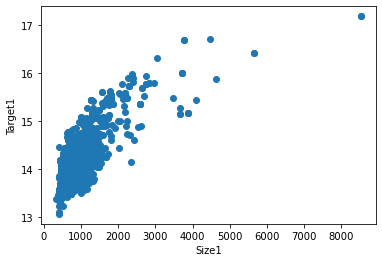

Text(0.5, 0, 'Bedrooms1')

Text(0, 0.5, 'Target1')

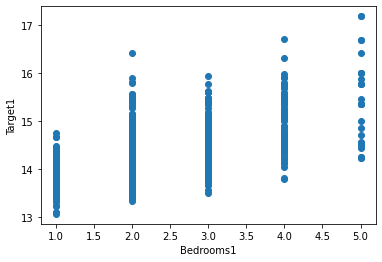

Text(0.5, 0, 'Bathrooms1')

Text(0, 0.5, 'Target1')

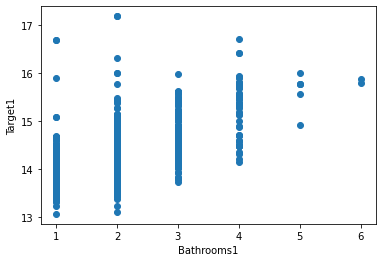

Text(0.5, 0, 'Built Year')

Text(0, 0.5, 'Target1')

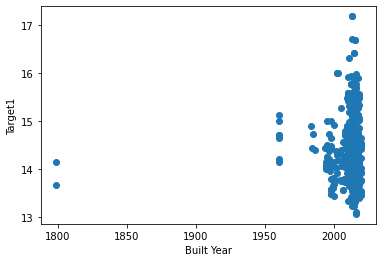

Text(0.5, 0, 'Region1_RCR')

Text(0, 0.5, 'Target1')

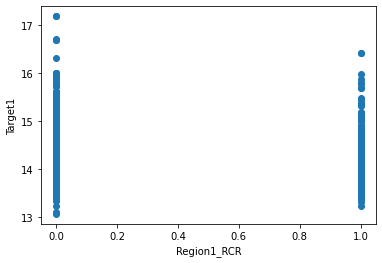

Text(0.5, 0, 'Tenure1_LEASEHOLD')

Text(0, 0.5, 'Target1')

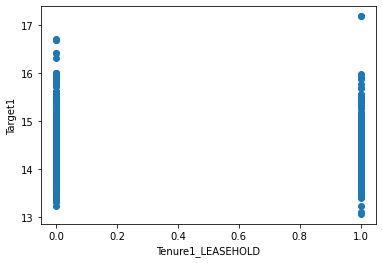

Text(0.5, 0, 'No. of Units1')

Text(0, 0.5, 'Target1')

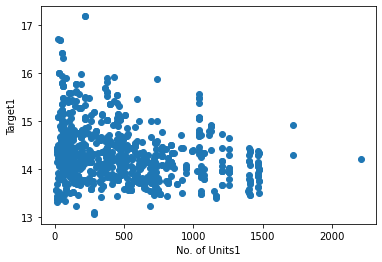

Text(0.5, 0, 'Region1_OCR')

Text(0, 0.5, 'Target1')

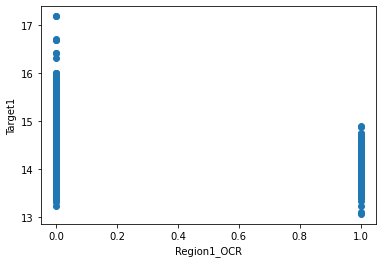

In [86]:
for i in corr_field:
    plt.scatter(condo_df2[i],y_log)
    plt.xlabel(i)
    plt.ylabel("Target1")
    plt.show()

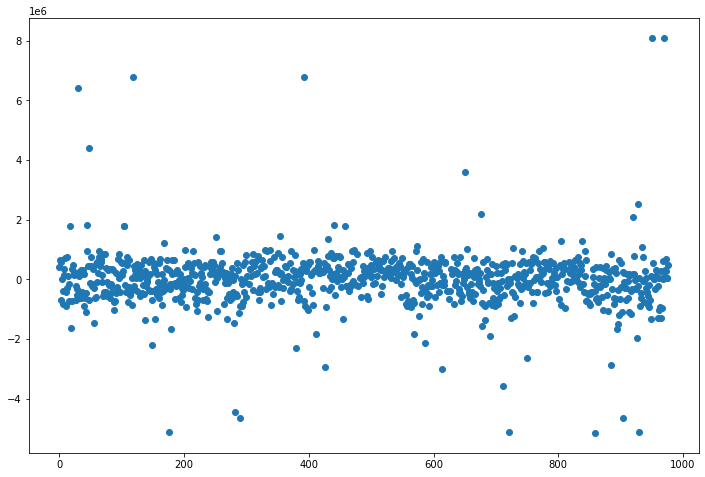

In [87]:
fit.resid.plot(style='o', figsize=(12,8));

In [88]:
condo_df.groupby('Region1')['Target1'].max()

Region1
CCR    28800000.0
OCR     2950000.0
RCR    13520000.0
Name: Target1, dtype: float64

In [89]:
condo_df.groupby('Region1')['Target1'].median()

Region1
CCR    2354000.0
OCR    1060000.0
RCR    1597000.0
Name: Target1, dtype: float64

In [90]:
condo_df['Region1'].value_counts()


RCR    334
CCR    319
OCR    261
Name: Region1, dtype: int64

In [91]:
condo_df1 =condo_df[['Target1','Property Name','Address','Size1','Built Year','Bedrooms1','Bathrooms1','No. of Units1','Region1']]
condo_df1.nlargest(10, 'Target1')

,Target1,Property Name,Address,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,Region1
118,28800000.0,Marina Bay Suites,3 Central Boulevard (018965),8513,2013.0,5.0,NaN,221.0,CCR
392,28800000.0,Marina Bay Suites,3 Central Boulevard (018965),8513,2013.0,5.0,NaN,221.0,CCR
30,18000000.0,Boulevard Vue,11 Cuscaden Walk (249697),4478,2013.0,4.0,4.0,28.0,CCR
950,17600000.0,Skyline @ Orchard Boulevard,23 Angullia Park (239975),3767,2015.0,5.0,1.0,40.0,CCR
970,17600000.0,Skyline @ Orchard Boulevard,23 Angullia Park (239975),3767,2015.0,5.0,1.0,40.0,CCR
484,13520000.0,Meyerhouse,128 Meyer Road (437938),5662,NaN,NaN,4.0,56.0,RCR
761,13500000.0,Meyerhouse,128 Meyer Road (437938),5662,NaN,5.0,4.0,56.0,RCR
47,12221886.0,The Ritz-Carlton Residences,65 Cairnhill Road (229721),3057,2011.0,4.0,NaN,58.0,CCR
197,8800000.0,The Tomlinson,20 Cuscaden Road (249726),3703,2002.0,5.0,NaN,29.0,CCR
556,8800000.0,The Tomlinson,20 Cuscaden Road (249726),3703,2002.0,5.0,NaN,29.0,CCR


### Volin chart to view the variances among regions

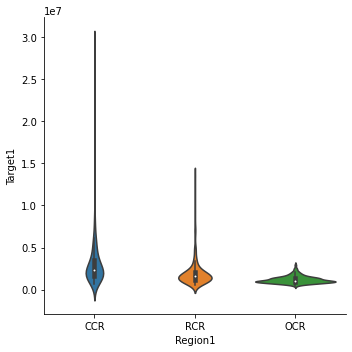

In [92]:
sns.catplot(x="Region1",y="Target1",data=condo_df1,kind="violin")
plt.savefig('region.png')
plt.show()

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [94]:
#Separate our features from our target

X = condo_df1.loc[:,['Size1','Built Year','Bedrooms1','Bathrooms1','No. of Units1']]

y = condo_df1['Target1']

# create overall quality squared term, which we expect to 
# help based on the relationship we see in the pair plot 
X['OQ2'] = X['Size1'] ** 2

In [95]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 0 to 976
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Size1          914 non-null    int64  
 1   Built Year     436 non-null    float64
 2   Bedrooms1      796 non-null    float64
 3   Bathrooms1     814 non-null    float64
 4   No. of Units1  913 non-null    float64
 5   OQ2            914 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 90.0 KB


In [96]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [97]:
X_train.columns

Index(['Size1', 'Built Year', 'Bedrooms1', 'Bathrooms1', 'No. of Units1',
       'OQ2'],
      dtype='object')

In [98]:
X_train.shape

(548, 6)

In [99]:
X_val.shape

(183, 6)

In [100]:
X_test.shape

(183, 6)

In [101]:
selected_columns = ['Size1','Bedrooms1','Bathrooms1','No. of Units1', 'OQ2']

In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 150 to 318
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Size1          548 non-null    int64  
 1   Built Year     265 non-null    float64
 2   Bedrooms1      480 non-null    float64
 3   Bathrooms1     489 non-null    float64
 4   No. of Units1  548 non-null    float64
 5   OQ2            548 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 30.0 KB


In [103]:
X_train.head()

,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,OQ2
150,560,2008.0,NaN,1.0,486.0,313600
298,711,2013.0,1.0,NaN,1145.0,505521
456,527,NaN,1.0,1.0,1206.0,277729
725,1097,2013.0,3.0,NaN,680.0,1203409
936,560,2016.0,1.0,NaN,80.0,313600


In [104]:
X_train.fillna(condo_df1.median(), inplace= True)
X_train

C:\Users\igung\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,OQ2
150,560,2008.0,2.0,1.0,486.0,313600
298,711,2013.0,1.0,2.0,1145.0,505521
456,527,2014.0,1.0,1.0,1206.0,277729
725,1097,2013.0,3.0,2.0,680.0,1203409
936,560,2016.0,1.0,2.0,80.0,313600
911,963,2008.0,2.0,2.0,206.0,927369
94,1012,2014.0,4.0,2.0,186.0,1024144
458,1270,2014.0,3.0,3.0,96.0,1612900
632,840,2009.0,2.0,2.0,55.0,705600
957,377,2012.0,1.0,1.0,36.0,142129


### Lasso regression to see key features.

In [105]:
lasso_model = Lasso(alpha = 1000000) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X_train.loc[:,selected_columns], y_train)

Lasso(alpha=1000000)

In [106]:
list(zip(selected_columns, lasso_model.coef_))

[('Size1', 1224.8146366096519),
 ('Bedrooms1', -0.0),
 ('Bathrooms1', -0.0),
 ('No. of Units1', -560.8583274455418),
 ('OQ2', 0.23358800317722828)]

In [107]:
np.random.seed(6)

X_train_collinear = X_train.loc[:,selected_columns]
X_train_collinear['Size2'] = (X_train_collinear['Size1'] + 
                                      2500 * np.random.randn(X_train.shape[0]))

X_train_collinear.corr() #notice .95 correlation b/w Lot Area and its "clone"

,Size1,Bedrooms1,Bathrooms1,No. of Units1,OQ2,Size2
Size1,1.000000,0.645290,0.560754,-0.083599,0.885078,0.305199
Bedrooms1,0.645290,1.000000,0.632207,0.045787,0.397372,0.256255
Bathrooms1,0.560754,0.632207,1.000000,-0.061411,0.259215,0.163112
No. of Units1,-0.083599,0.045787,-0.061411,1.000000,-0.083882,-0.075394
OQ2,0.885078,0.397372,0.259215,-0.083882,1.000000,0.259035
Size2,0.305199,0.256255,0.163112,-0.075394,0.259035,1.000000


In [108]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

model = sm.OLS(y_train, sm.add_constant(X_train_collinear))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Target1   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     491.0
Date:                Mon, 21 Sep 2020   Prob (F-statistic):          3.30e-215
Time:                        19:05:58   Log-Likelihood:                -8274.8
No. Observations:                 548   AIC:                         1.656e+04
Df Residuals:                     541   BIC:                         1.659e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.104e+05   1.18e+05      6.012      0.000    4.78e+05    9.43e+05
Size1          1367.5082    179.856      7.603      0.000    1014.207    1720.809
Bedrooms1      2514.9959      6e+04      0.042      0.967   -1.15e+05     1.2e+05
Bathrooms1    -7.163e+04   6.68e+04     -1.072      0.284   -2.03e+05    5.96e+04
No. of Units1  -574.1778     93.613     -6.134      0.000    -758.067    -390.288
OQ2               0.2186      0.022      9.937      0.000       0.175       0.262
Size2            -9.2784     15.534     -0.597      0.551     -39.793      21.236
==============================================================================
Omnibus:                       93.568   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1028.982
Skew:                           0.329   Prob(JB):                    3.62e-224
Kurtosis:                       9.681   Cond. No.                     1.67e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Using ridge regression to check on key features.

In [109]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_ridge.coef_))

Ridge(alpha=1000000000000)

[('Size1', 0.08326402635316602),
 ('Bedrooms1', 0.00013176251630598492),
 ('Bathrooms1', 0.00013960599175631304),
 ('No. of Units1', -0.05346581520965359),
 ('OQ2', 0.40307576956044183),
 ('Size2', 0.08762053440334405)]

In [110]:
lr_model_lasso = Lasso(alpha = 100000)
lr_model_lasso.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_lasso.coef_))

Lasso(alpha=100000)

[('Size1', 1241.8553664649894),
 ('Bedrooms1', -0.0),
 ('Bathrooms1', -0.0),
 ('No. of Units1', -568.878461549076),
 ('OQ2', 0.23238774134281526),
 ('Size2', -8.593136617485941)]

In [111]:
y_train

150     1250000.0
298      760000.0
456      860000.0
725     1028000.0
936      800000.0
911     2060000.0
94      1700000.0
458     5084000.0
632     1550000.0
957      678000.0
728     8300000.0
509     1628000.0
613     1440000.0
837     1000000.0
594      825000.0
317     3164000.0
550     5000000.0
279     1289000.0
269     2365000.0
259     1360000.0
152     1085530.0
394     1520000.0
363     4120000.0
796     1403000.0
859     4300000.0
223     1944000.0
923     1580000.0
746     1839000.0
884     5280000.0
776     1668000.0
703     3300000.0
234     1750000.0
162     2303590.0
84       930000.0
255      789000.0
810     1864000.0
931     1250000.0
538     3340000.0
154     1680000.0
346     1360000.0
405     1357000.0
46       980000.0
892     3280000.0
592     8800000.0
505      879000.0
442     1180000.0
739     1550000.0
735     2346000.0
1       1305000.0
41      1620000.0
10      3715740.0
696     1400000.0
575     2300000.0
910      800000.0
583     2101000.0
100     31

In [112]:
X_test.head()

,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,OQ2
398,689,2016.0,2.0,2.0,726.0,474721
917,1184,2008.0,3.0,2.0,1111.0,1401856
371,2820,NaN,4.0,4.0,56.0,7952400
374,657,NaN,2.0,2.0,117.0,431649
379,474,NaN,1.0,1.0,548.0,224676


In [113]:
X_test.fillna(condo_df1.median(), inplace= True)
X_test

C:\Users\igung\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Size1,Built Year,Bedrooms1,Bathrooms1,No. of Units1,OQ2
398,689,2016.0,2.0,2.0,726.0,474721
917,1184,2008.0,3.0,2.0,1111.0,1401856
371,2820,2014.0,4.0,4.0,56.0,7952400
374,657,2014.0,2.0,2.0,117.0,431649
379,474,2014.0,1.0,1.0,548.0,224676
522,721,2017.0,2.0,2.0,260.0,519841
755,1023,2014.0,3.0,2.0,841.0,1046529
642,753,2014.0,2.0,2.0,215.0,567009
590,473,2016.0,1.0,1.0,726.0,223729
31,915,2017.0,3.0,2.0,54.0,837225


### Checking predicted vs test data variances

In [114]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

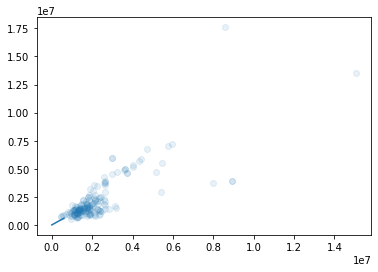

In [115]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))

In [116]:
r2_score(y_test, test_set_pred)

0.6369318601766212

### Mean square error calculation.

In [117]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

690996.1717017199